In [3]:
import os
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as ffn

import torchaudio

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import IPython
import pandas as pd

1. Firstly, let's implement baseline classification model   
    1.1. Simple CNN-based model   
    1.2 Complicated sota CNN for audio-classification task    
2. Novel approach with LLM

0. 

## 0. Quick audio analysis

In [4]:
data_dir = '/home/stud_valery/heartbeats_classification/data/physionet/audio/'
files = os.listdir(data_dir)
print(len(files))
audio_dur = []
for file in files:
    audio, sr = torchaudio.load(data_dir+file)
    audio_dur.append(audio.shape[1]/sr)

2934


In [ ]:
audio_dur = np.array(audio_dur)
print(audio_dur.mean(), 3*audio_dur.std(), audio_dur.mean() + audio_dur.std())

22.46175293209876 37.15344279602019 34.84623386410549


Since we have different length of audio, we simply will pad/slice the audios (as CNN requires constant input shape). Chosen length is 35 s. (mean + std)

### Makedataset, weighted sampler

In [ ]:
base_dir='/home/stud_valery/heartbeats_classification/data/physionet/'
df = pd.read_csv(base_dir + '/dataset.csv')
# df_dict = df.set_index('filename').to_dict()['class']

In [ ]:
df["label"].value_counts()

0    2331
1     603
Name: label, dtype: int64

In [ ]:
word_to_number = {"Normal": 0, "Abnormal": 1}
df['label'] = df['label'].map(word_to_number)

In [ ]:
df_dict = df.set_index('id').to_dict()['label']

In [ ]:
from MakeDataset import MakeDataset
dataset = MakeDataset('/home/stud_valery/heartbeats_classification/data/physionet','train')

get train dataset from /home/stud_valery/heartbeats_classification/data/physionet...:   0%|          | 0/2347 [00:00<?, ?it/s]/home/stud_valery/anaconda3/envs/torchenv/lib/python3.9/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
get train dataset from /home/stud_valery/heartbeats_classification/data/physionet...: 100%|██████████| 2347/2347 [00:19<00:00, 123.24it/s]


In [ ]:
y_train = [dataset.targets[i] for i in range(len(dataset))]
class_sample_count = np.array(
    [len(np.where(y_train == t)[0]) for t in np.unique(y_train)])
print(class_sample_count)
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in y_train])
samples_weight = torch.from_numpy(samples_weight)
print(samples_weight)

NameError: name 'np' is not defined

In [ ]:
from torch.utils.data import DataLoader, WeightedRandomSampler
import numpy as np
import torch
sampler = WeightedRandomSampler(samples_weight, len(dataset), replacement=True)
train_dataloader = DataLoader(dataset=dataset, batch_size=30,
                              num_workers=8, drop_last=True,
                              sampler=sampler)

In [ ]:
for batch in train_dataloader:
    print(batch[1])
    break

tensor([0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1,
        1, 0, 0, 1, 0, 0])


In [ ]:
for item in train_dataloader:
    print(1)

In [ ]:
from torchmetrics import F1Score, Accuracy, Precision, Recall

In [ ]:
target = torch.concat((torch.zeros(8), torch.ones(2)))
preds = torch.zeros(10)
f1 = F1Score(task="multiclass", num_classes=3)
acc = Accuracy(task="multiclass", num_classes=3)
pr = Precision(task="multiclass", num_classes=2, average="macro")
rc = Recall(task="multiclass", num_classes=2, average="macro")
print("f1: ",f1(preds, target))
print("acc: ", acc(preds, target))
print("pr: ", pr(preds, target))
print("rc: ", rc(preds, target))


f1:  tensor(0.8000)
acc:  tensor(0.8000)
pr:  tensor(0.5000)


### Split dataset

In [ ]:
import random, os, shutil
source_directory = '/home/stud_valery/heartbeats_classification/data/physionet/audio'
train_directory = '/home/stud_valery/heartbeats_classification/data/physionet/train'
test_directory = '/home/stud_valery/heartbeats_classification/data/physionet/test'
train_ratio = 0.8  # Adjust this value to set the train-test ratio
if not os.path.exists(train_directory):
    os.makedirs(train_directory)

if not os.path.exists(test_directory):
    os.makedirs(test_directory)

file_list = os.listdir(source_directory)
random.shuffle(file_list)
split_point = int(train_ratio * len(file_list))
for i, file_name in enumerate(file_list):
    source_path = os.path.join(source_directory, file_name)
    if i < split_point:
        target_path = os.path.join(train_directory, file_name)
    else:
        target_path = os.path.join(test_directory, file_name)
    shutil.copy(source_path, target_path)

## Large CNN testing (PANNs, firstly)

In [ ]:
from models.PANNs.CNN14 import Cnn14
import torch
from MakeDataset import MakeDataset
from models.PANClassifier import PANClassifier

model = PANClassifier(num_classes=2, device=0)
dataset = MakeDataset('/home/stud_valery/heartbeats_classification/data/physionet','train', raw_audio=True)


/home/stud_valery/anaconda3/envs/torchenv/lib/python3.9/site-packages/torchlibrosa/stft.py:686: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  self.melW = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels,
get train dataset from /home/stud_valery/heartbeats_classification/data/physionet...: 100%|██████████| 100/100 [00:00<00:00, 196.23it/s]


In [ ]:
dataset[0]

(tensor([0.0070, 0.0087, 0.0101,  ..., 0.0247, 0.0240, 0.0232]), 1)

In [ ]:
model(dataset[0][0].unsqueeze(0))

torch.Size([1, 560000]) tensor([[0.0012, 0.0016, 0.0020,  ..., 0.0000, 0.0000, 0.0000]])


tensor([[0.5839, 0.4161]], grad_fn=<SoftmaxBackward0>)

## 1. Transform to mel space


In [ ]:
mfcc_transform = torchaudio.transforms.MFCC(
    sample_rate=16000,
    n_mfcc=13,
    melkwargs={'n_fft': 128, 'hop_length': 160, 'n_mels': 23, 'center': False}
)
mel_transform = torchaudio.transforms.MelSpectrogram()

/home/stud_valery/anaconda3/envs/torchenv/lib/python3.9/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [ ]:
audio1, sr  = torchaudio.load('/0a0b16288ff78515d6c091cfeb813bad.wav')
mel1 = mel_transform(audio1)
audio2, sr = torchaudio.load('/0a5d816bb748ea79ff248d0672f0e3b2.wav')
mel2 = mel_transform(audio2)

In [ ]:
mel_transform(pad_audio2).shape

torch.Size([128, 825])

In [ ]:
#audio1 is man
IPython.display.Audio('')

In [ ]:
#audio2 is woman
IPython.display.Audio('')

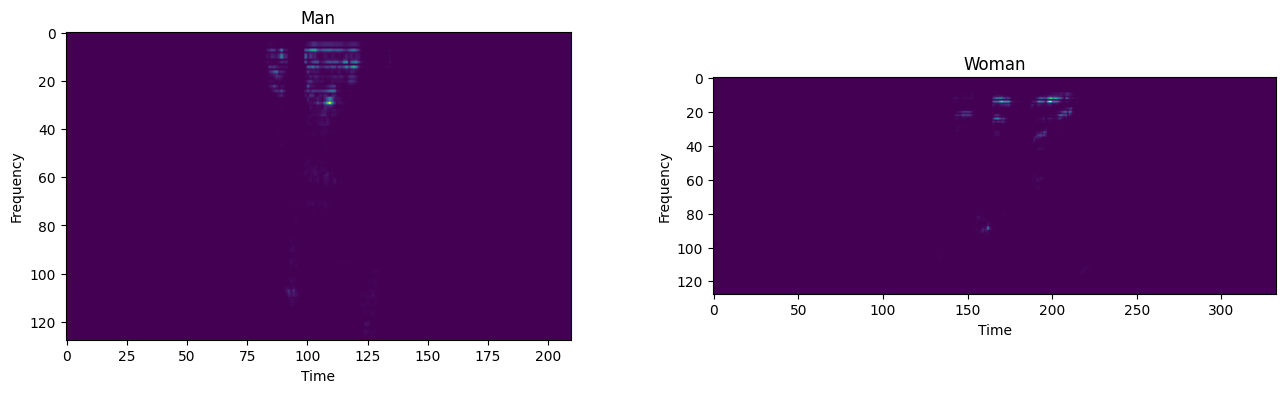

In [ ]:
plt.figure(figsize=[16, 4])
plt.subplot(1, 2, 1)
plt.title("Man"); plt.xlabel("Time"); plt.ylabel("Frequency")
plt.imshow(mel1[0])

plt.subplot(1, 2, 2)
plt.title("Woman"); plt.xlabel("Time"); plt.ylabel("Frequency")
plt.imshow(mel2[0]);

## 2. Dataset


Data shuffle

In [ ]:
import os
import random
from shutil import copyfile

base_dir = '/home/stud_valery/simple_audio_classification/data/'
data_dir = base_dir + 'train/'

# Set the ratio for the train-test split (e.g., 80% train, 20% test)
train_ratio = 0.8
test_ratio = 0.2

# Get a list of all the files in the directory
file_list = os.listdir(data_dir)

# Randomly shuffle the list of files
random.shuffle(file_list)

# Calculate the number of files for training and testing
num_files = len(file_list)
num_train = int(train_ratio * num_files)
num_test = num_files - num_train

# Create separate directories for train and test data
train_directory = base_dir + 'train_split/'
test_directory = base_dir + 'test_split/'

os.makedirs(train_directory, exist_ok=True)
os.makedirs(test_directory, exist_ok=True)

# Copy files to the train directory
for file_name in file_list[:num_train]:
    source_path = os.path.join(data_dir, file_name)
    destination_path = os.path.join(train_directory, file_name)
    copyfile(source_path, destination_path)

# Copy files to the test directory
for file_name in file_list[num_train:]:
    source_path = os.path.join(data_dir, file_name)
    destination_path = os.path.join(test_directory, file_name)
    copyfile(source_path, destination_path)

In [ ]:
df = pd.read_csv('/home/reznik24/Contests/targets.tsv', sep='\t', header=None, names=['filename', 'class'])

In [ ]:
targets = np.array(df['Class'])
np.bincount(targets)

array([7620, 6316])

Training dataset contains 7620 males voices and 6316 females. Unbalanced, but not much, so it's not that important

## 3. Model architecture

In [ ]:
import torch
params = torch.load('/home/stud_valery/simple_audio_classification/data/train_record/no_name/params/last_epoch.pt',\
                     map_location='cuda:'+str(0))
# model.load_state_dict(params)

<All keys matched successfully>

In [ ]:
print(model)

Model(
  (conv_blocks): ModuleList(
    (0): ConvBlock(
      (block): Sequential(
        (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(2, 2))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): ConvBlock(
      (block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (2-6): 5 x ConvBlock(
      (block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (7): ConvBlock(
      (block): Sequential(
        (0): Conv2d(64, 1

In [ ]:
#calculating shapes
def base_formula(n_in, k, p, s):
    return int((n_in + 2*p - k)/s) + 1
def shape_after_pooling(h, w, ker_hw, p=0):
    return base_formula(h, ker_hw, p, ker_hw), base_formula(w, ker_hw, p, ker_hw)
def shape_after_conv2d(h, w, ker_hw, p=0, s=1):
    return base_formula(h, ker_hw, p, s), base_formula(w, ker_hw, p, s)

# Inference Tool

In [1]:
#initialize the model and some dataset
from MakeDataset import MakeDataset
from models.CNNClassifier import Model
import torch
dataset = MakeDataset('/home/stud_valery/heartbeats_classification/data/physionet', 'test', unlabeled_mode=False)

model = Model(num_classes=2, device=0).to(0)
params = torch.load('/home/stud_valery/heartbeats_classification/data/train_record/balanced/best_model',\
                     map_location='cuda:0')
model.load_state_dict(params)
model.eval()
None

get test dataset from /home/stud_valery/heartbeats_classification/data/physionet...:   0%|          | 0/587 [00:00<?, ?it/s]/home/stud_valery/anaconda3/envs/torchenv/lib/python3.9/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
get test dataset from /home/stud_valery/heartbeats_classification/data/physionet...: 100%|██████████| 587/587 [00:03<00:00, 147.73it/s]


In [11]:
#random predict from given dataset or file
import IPython
import random
model.eval()
def predict(filename=None):
    if filename==None:
        audio, filepath = random.choice(dataset)
    else:
        filepath = filename
        audio = dataset.process_audio_file(filepath)
        print(audio.shape)
    with torch.no_grad():
        out = model(audio.unsqueeze(0).to(0))
    out = 'normal' if out < 0.5 else 'abnormal'
    print(out)
    return filepath
filepath = predict()
# IPython.display.Audio(filepath, rate=16000)

normal


In [13]:
s, total = 0, len(dataset)
for item in dataset:
    if model(item[0].unsqueeze(0).to(0)) == 0:
        s += 1
print(s/total)

0.9004237288135594


In [16]:
#evaluate or get predictions on dataset
from Evaluater import Evaluater
from torch.utils.data import DataLoader
predict_dataloader = DataLoader(dataset=dataset, batch_size=60,
                              shuffle=False, num_workers=8, drop_last=False)
evaluater = Evaluater(model, predict_dataloader, device=0)
evaluater.get_predicts('./data/')
None

/home/stud_valery/anaconda3/envs/torchenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Calculating predictions...:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([60, 86016])


Calculating predictions...:  50%|█████     | 1/2 [00:01<00:01,  1.10s/it]

torch.Size([55, 86016])


Calculating predictions...: 100%|██████████| 2/2 [00:01<00:00,  1.36it/s]
